In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import joblib

In [2]:
# read fold for check
f1 = pd.read_csv("../kitt/f1.csv")
f2 = pd.read_csv("../kitt/f2.csv")
f3 = pd.read_csv("../kitt/f3.csv")
f4 = pd.read_csv("../kitt/f4.csv")
f5 = pd.read_csv("../kitt/f5.csv")

# read raw data
raw_data = pd.read_csv("../raw_data/data.csv")

# Review

In [3]:
# run it once
raw_data = raw_data.drop(labels='Unnamed: 32', axis=1)
raw_data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [4]:
print("########## the fold ############")
print("fold1: "+ str(len(f1)))
print("fold2: "+ str(len(f2)))
print("fold3: "+ str(len(f3)))
print("fold4: "+ str(len(f4)))
print("fold5: "+ str(len(f5)))
print("\ntotal: " + str(len(f1) + len(f2) + len(f3) + len(f4) + len(f5)))
print("################################")

########## the fold ############
fold1: 91
fold2: 91
fold3: 91
fold4: 91
fold5: 91

total: 455
################################


In [5]:
y_f1 = f1[f1.columns[1]]
le = LabelEncoder()
y_f1 = np.array(le.fit_transform(y_f1))
print("y_f1:", le.classes_)
y_f2 = f2[f2.columns[1]]
le = LabelEncoder()
y_f2 = np.array(le.fit_transform(y_f2))
print("y_f2:",le.classes_)
y_f3 = f3[f3.columns[1]]
le = LabelEncoder()
y_f3 = np.array(le.fit_transform(y_f3))
print("y_f3:",le.classes_)
y_f4 = f4[f4.columns[1]]
le = LabelEncoder()
y_f4 = np.array(le.fit_transform(y_f4))
print("y_f4:",le.classes_)
y_f5 = f5[f5.columns[1]]
le = LabelEncoder()
y_f5 = np.array(le.fit_transform(y_f5))
print("y_f5:",le.classes_)

y_f1: ['B' 'M']
y_f2: ['B' 'M']
y_f3: ['B' 'M']
y_f4: ['B' 'M']
y_f5: ['B' 'M']


In [6]:
# check balance in each fold
print("------ fold ------")
print("f1 positive: " + str(sum(y_f1)))
print("f1 negative: " + str(len(f1) - sum(y_f1)))
print("------------------")
print("f2 positive: " + str(sum(y_f2)))
print("f2 negative: " + str(len(f2) - sum(y_f2)))
print("------------------")
print("f3 positive: " + str(sum(y_f3)))
print("f3 negative: " + str(len(f3) - sum(y_f3)))
print("------------------")
print("f4 positive: " + str(sum(y_f4)))
print("f4 negative: " + str(len(f4) - sum(y_f4)))
print("------------------")
print("f5 positive: " + str(sum(y_f5)))
print("f5 negative: " + str(len(f5) - sum(y_f5)))
print("------------------")

------ fold ------
f1 positive: 34
f1 negative: 57
------------------
f2 positive: 34
f2 negative: 57
------------------
f3 positive: 34
f3 negative: 57
------------------
f4 positive: 34
f4 negative: 57
------------------
f5 positive: 34
f5 negative: 57
------------------


# Function

In [15]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1


In [46]:
def evaluate_no_prob(param,split):
    joblib.load("../DTC/models_pg3/param{}/dtc_model_{}.pkl".format(param, split))
    ############## validate set ################
    print("############## validate set ################")
    y_pred_val = loaded_model.predict(x_val)
    print
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()
    
    # calculate roc curves
    fpr, tpr, thresholds = metrics.roc_curve(y_true,  y_prob[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test = loaded_model.predict(x_test)
    # Print the predictions
    # print(y_pred)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_test = sensitivity(cm_test)
    spec_test = specificity(cm_test)
    acc_test = accuracy(cm_test)
    pre_test = precision(cm_test)
    f1_score_test = f1(cm_test)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_test.shape[1]),
           yticks=np.arange(cm_norm_test.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Test set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_test.max() / 2.
    for i in range(cm_norm_test.shape[0]):
        for j in range(cm_norm_test.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_test[i, j] > thresh else "black",
                   fontsize=20)

    plt.show()

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    return cm_val,cm_test,auc1,auc2


In [47]:
def cal_score_all(cm_val):
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

In [134]:
def plot_cm_val(cm_val, save=False):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

In [135]:
def plot_cm_test(cm_test, save=False):
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_test.shape[1]),
           yticks=np.arange(cm_norm_test.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Test set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_test.max() / 2.
    for i in range(cm_norm_test.shape[0]):
        for j in range(cm_norm_test.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_test[i, j] > thresh else "black",
                   fontsize=20)
    if save is not False:
        save_path = '{}_{}.png'.format(split)
        plt.savefig(save_path)
        print("Save fig at {}".format(save_path))
    plt.show()

In [125]:
def plot_ROC():
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [126]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
    
def thresholding(y_val, y_pred_val):
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_val[:, 1])
    # get the best threshold
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    print('FPR: %.4f\nTPR: %.4f' %(fpr[ix], tpr[ix]))
    y_pred_val_new = to_labels(y_pred_val[:, 1], best_thresh)
    return y_pred_val_new

In [174]:
def evaluate(param,split):
    loaded_model = joblib.load("../DTC/models_pg3/param{}/dtc_model_{}.joblib".format(param, split))
    print("############## validate set ################")
    y_pred_val_raw = loaded_model.predict_proba(x_val)
    y_pred_val = thresholding(y_val, y_pred_val_raw)
    
    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_val)
    
    # plot confusion matrix
    plot_cm_val(cm_val)
    
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test_raw = loaded_model.predict_proba(x_test)
    y_pred_test = thresholding(y_test, y_pred_test_raw)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    cal_score_all(cm_test)

    # plot confusion matrix
    plot_cm_test(cm_test)

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val_raw[:,1])
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val_raw[:,1])*100
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test_raw[:,1])
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test_raw[:,1])*100
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.2f%%" % auc1)
    print("AUC test: %.2f%%" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    return cm_val,cm_test,auc1,auc2

In [66]:
def ROC_split(split1,split2,split3,split4,split5):
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)*100
    
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr3, tpr3, thr3 = metrics.roc_curve(y_test,  y_pred_test)
    auc3 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr4, tpr4, thr4 = metrics.roc_curve(y_test,  y_pred_test)
    auc4 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    fpr5, tpr5, thr5 = metrics.roc_curve(y_test,  y_pred_test)
    auc5 = metrics.roc_auc_score(y_test,  y_pred_test)*100
    
    # gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    # ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC split1: %.2f%%" % auc1)
    print("AUC split2: %.2f%%" % auc2)
    print("AUC split3: %.2f%%" % auc1)
    print("AUC split4: %.2f%%" % auc2)
    print("AUC split5: %.2f%%" % auc1)
    
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.2f%%" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc2))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc3))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc4))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.2f%%" % auc5))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()

In [137]:
def setup(split):
    # setting split and path
    path = "../kitt/DATA_progress3/"
    train_path = "{}/{}/train/train_oversampling.csv".format(path,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val.csv".format(path,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[2:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[1]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

# ----------------------- PARAMETER 1 -----------------------

# Split1

In [205]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## step train - split1

In [206]:
# dtc = DecisionTreeClassifier()

# parameters = {
#     'criterion' : ['gini', 'entropy'],
#     'max_depth' : range(2, 32, 1),
#     'min_samples_leaf' : range(1, 10, 1),
#     'min_samples_split' : range(2, 10, 1),
#     'splitter' : ['best', 'random']
# }

# grid_search = GridSearchCV(dtc, parameters, cv = 5, n_jobs = -1, verbose = 1)
# grid_search.fit(x_val, y_val)
# print('Best criterion parameter:', grid_search.best_params_['criterion'])
# print('Best max_depth parameter:', grid_search.best_params_['max_depth'])
# print('Best min_samples_leaf parameter:', grid_search.best_params_['min_samples_leaf'])
# print('Best min_samples_split parameter:', grid_search.best_params_['min_samples_split'])
# print('Best splitter parameter:', grid_search.best_params_['splitter'])
# print('Best score:', grid_search.best_score_)

In [207]:
# grid_search.best_params_

In [250]:
dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")

In [251]:
param = 1

In [252]:
def dtc_train(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")
    dtc.fit(x_train, y_train)
    joblib.dump(dtc, "../DTC/models_pg3/param{}/dtc_model_{}.joblib".format(param, split))

In [253]:
dtc_train(split)

../kitt/DATA_progress3//split1/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split1/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


############## validate set ################
Best Threshold=1.000000
FPR: 0.0351
TPR: 1.0000
Confusion Matrix
----------------
[[55  2]
 [ 0 34]] 

----------------
split1
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%


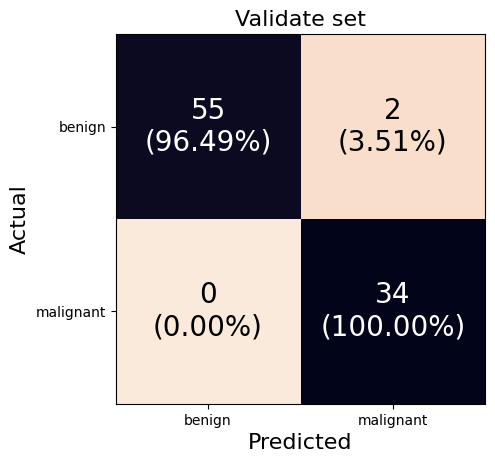

################# test set ##################
Best Threshold=1.000000
FPR: 0.0556
TPR: 0.9048
Confusion Matrix
----------------
[[68  4]
 [ 4 38]] 

----------------
split1
Sensitivity: 90.48%
Specificity: 94.44%
Accuracy: 92.98%
Precision: 90.48%
Sensitivity: 90.48%
Precision: 90.48%
F1: 90.48%


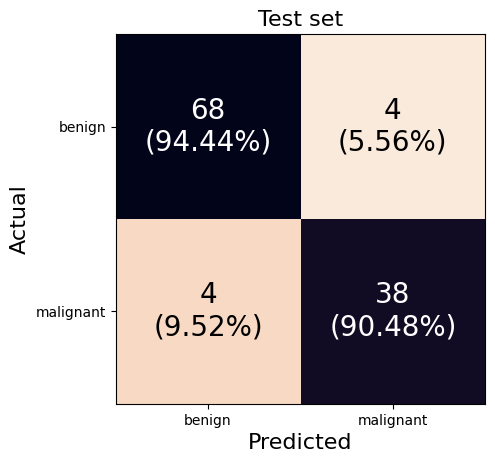

---------------------------------------
AUC validate: 98.25%
AUC test: 92.46%


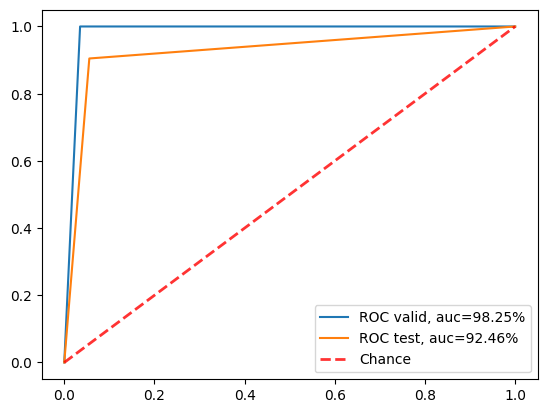

In [257]:
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

# Split2

In [507]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## step train - split2

In [523]:
dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")

In [524]:
param = 1

In [525]:
def dtc_train(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")
    dtc.fit(x_train, y_train)
    joblib.dump(dtc, "../DTC/models_pg3/param{}/dtc_model_{}.joblib".format(param, split))

In [526]:
dtc_train(split)

../kitt/DATA_progress3//split2/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split2/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


############## validate set ################
Best Threshold=0.333333
FPR: 0.0351
TPR: 1.0000
Confusion Matrix
----------------
[[55  2]
 [ 0 34]] 

----------------
split2
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%


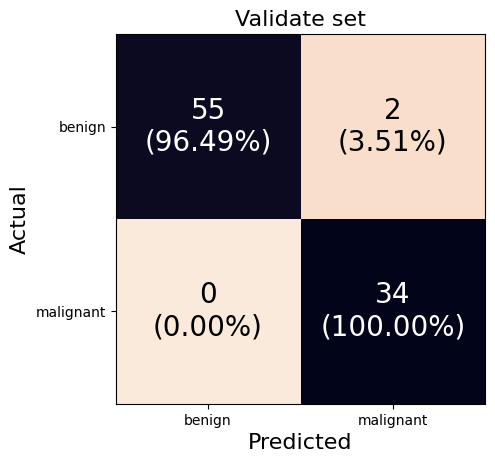

################# test set ##################
Best Threshold=0.333333
FPR: 0.0694
TPR: 0.8571
Confusion Matrix
----------------
[[67  5]
 [ 6 36]] 

----------------
split2
Sensitivity: 85.71%
Specificity: 93.06%
Accuracy: 90.35%
Precision: 87.80%
Sensitivity: 85.71%
Precision: 87.80%
F1: 86.75%


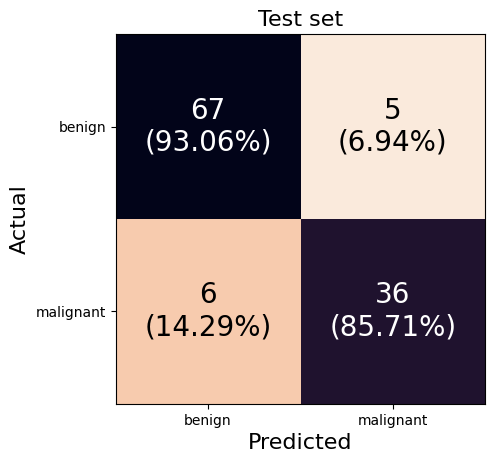

---------------------------------------
AUC validate: 98.19%
AUC test: 89.30%


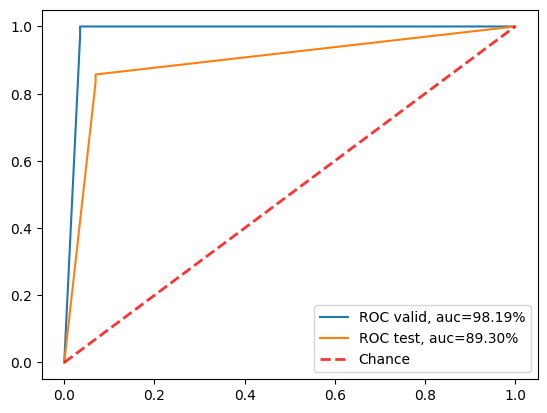

In [527]:
param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

# Split3

In [349]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## step train - split3

In [407]:
dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")

In [408]:
param = 1

In [409]:
def dtc_train(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")
    dtc.fit(x_train, y_train)
    joblib.dump(dtc, "../DTC/models_pg3/param{}/dtc_model_{}.joblib".format(param, split))

In [410]:
dtc_train(split)

../kitt/DATA_progress3//split3/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split3/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


############## validate set ################
Best Threshold=1.000000
FPR: 0.0351
TPR: 1.0000
Confusion Matrix
----------------
[[55  2]
 [ 0 34]] 

----------------
split3
Sensitivity: 100.00%
Specificity: 96.49%
Accuracy: 97.80%
Precision: 94.44%
Sensitivity: 100.00%
Precision: 94.44%
F1: 97.14%


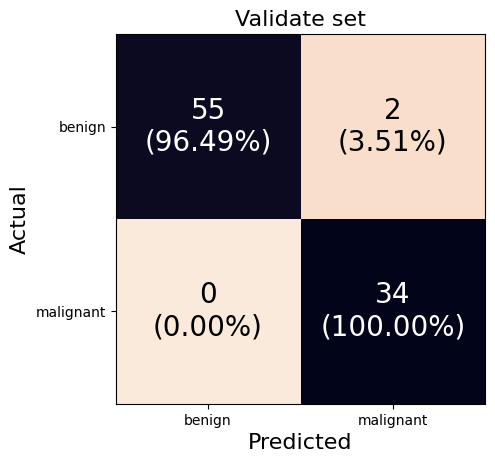

################# test set ##################
Best Threshold=1.000000
FPR: 0.0417
TPR: 0.8810
Confusion Matrix
----------------
[[69  3]
 [ 5 37]] 

----------------
split3
Sensitivity: 88.10%
Specificity: 95.83%
Accuracy: 92.98%
Precision: 92.50%
Sensitivity: 88.10%
Precision: 92.50%
F1: 90.24%


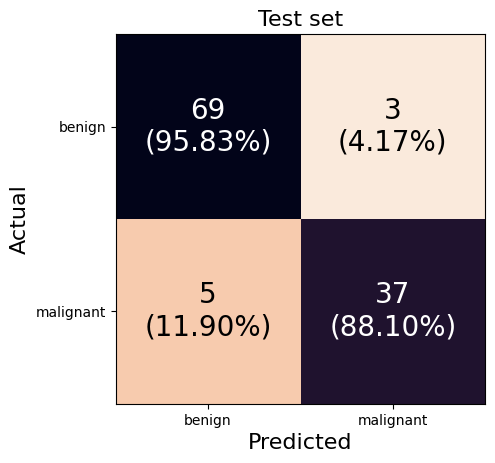

---------------------------------------
AUC validate: 98.25%
AUC test: 91.96%


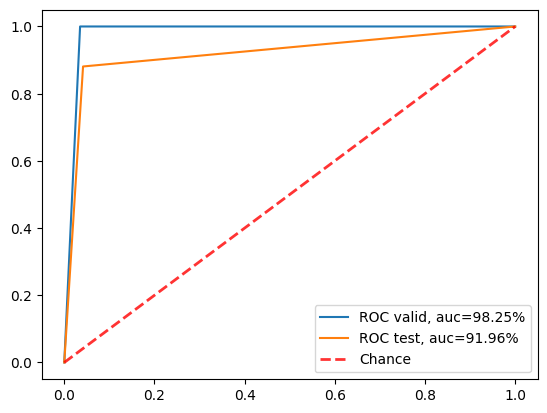

In [447]:

param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

# Split4

In [454]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## step train - split4

In [455]:
model = DecisionTreeClassifier(criterion="gini",
                             max_depth=22, min_samples_leaf=4, 
                             min_samples_split=4, splitter="random")

In [456]:
param = 1

In [457]:
def dtc_train(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")
    dtc.fit(x_train, y_train)
    joblib.dump(dtc, "../DTC/models_pg3/param{}/dtc_model_{}.joblib".format(param, split))

In [458]:
dtc_train(split)

../kitt/DATA_progress3//split4/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split4/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


############## validate set ################
Best Threshold=1.000000
FPR: 0.0175
TPR: 1.0000
Confusion Matrix
----------------
[[56  1]
 [ 0 34]] 

----------------
split4
Sensitivity: 100.00%
Specificity: 98.25%
Accuracy: 98.90%
Precision: 97.14%
Sensitivity: 100.00%
Precision: 97.14%
F1: 98.55%


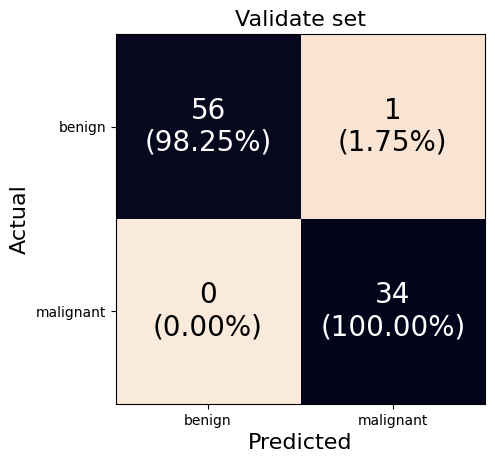

################# test set ##################
Best Threshold=1.000000
FPR: 0.0278
TPR: 0.9048
Confusion Matrix
----------------
[[70  2]
 [ 4 38]] 

----------------
split4
Sensitivity: 90.48%
Specificity: 97.22%
Accuracy: 94.74%
Precision: 95.00%
Sensitivity: 90.48%
Precision: 95.00%
F1: 92.68%


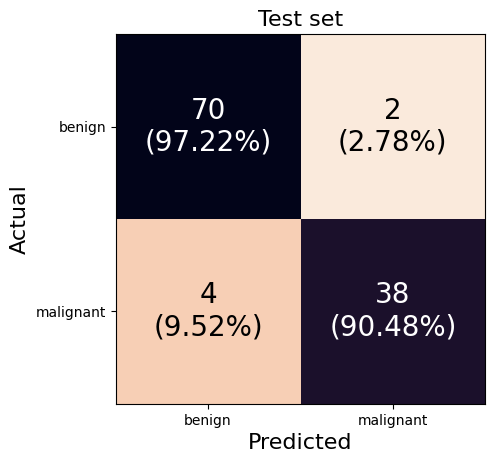

---------------------------------------
AUC validate: 99.12%
AUC test: 93.85%


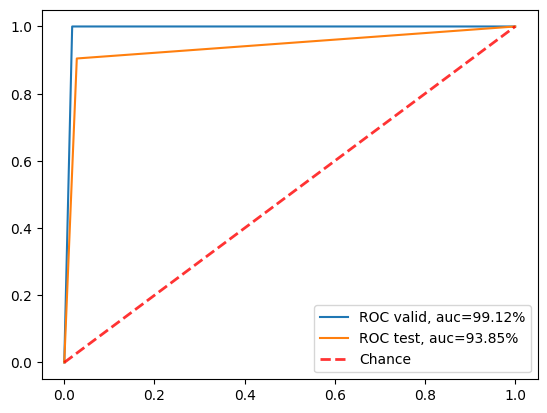

In [459]:
param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

# Split5

In [460]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../kitt/DATA_progress3//split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


## step train - split5

In [461]:
dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")

In [462]:
param = 1

In [463]:
def dtc_train(split):
    x_train,y_train,x_test,y_test,x_val,y_val = setup(split)
    dtc = DecisionTreeClassifier(criterion="entropy",
                             max_depth=21, min_samples_leaf=1, 
                             min_samples_split=4, splitter="random")
    dtc.fit(x_train, y_train)
    joblib.dump(dtc, "../DTC/models_pg3/param{}/dtc_model_{}.joblib".format(param, split))

In [464]:
dtc_train(split)

../kitt/DATA_progress3//split5/train/train_oversampling.csv
(456, 18)
(456, 16)
['B' 'M']
../kitt/DATA_progress3//test.csv
(114, 18)
(114, 16)
['B' 'M']
../kitt/DATA_progress3//split5/val/val.csv
(91, 18)
(91, 16)
['B' 'M']


############## validate set ################
Best Threshold=0.666667
FPR: 0.0702
TPR: 1.0000
Confusion Matrix
----------------
[[53  4]
 [ 0 34]] 

----------------
split5
Sensitivity: 100.00%
Specificity: 92.98%
Accuracy: 95.60%
Precision: 89.47%
Sensitivity: 100.00%
Precision: 89.47%
F1: 94.44%


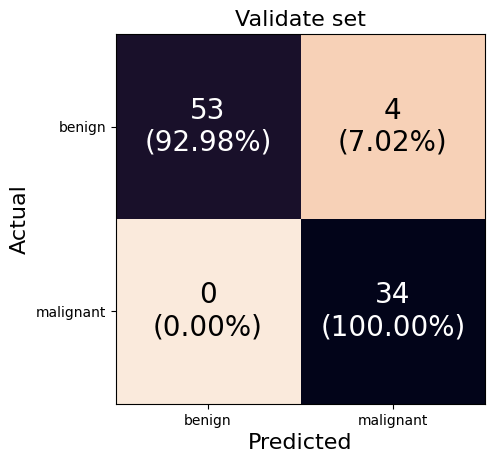

################# test set ##################
Best Threshold=0.666667
FPR: 0.0417
TPR: 0.9048
Confusion Matrix
----------------
[[69  3]
 [ 4 38]] 

----------------
split5
Sensitivity: 90.48%
Specificity: 95.83%
Accuracy: 93.86%
Precision: 92.68%
Sensitivity: 90.48%
Precision: 92.68%
F1: 91.57%


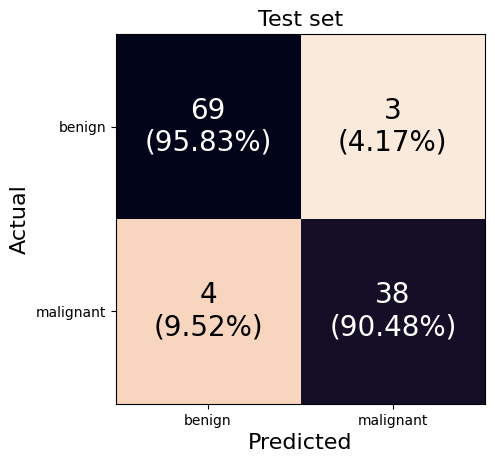

---------------------------------------
AUC validate: 98.04%
AUC test: 95.27%


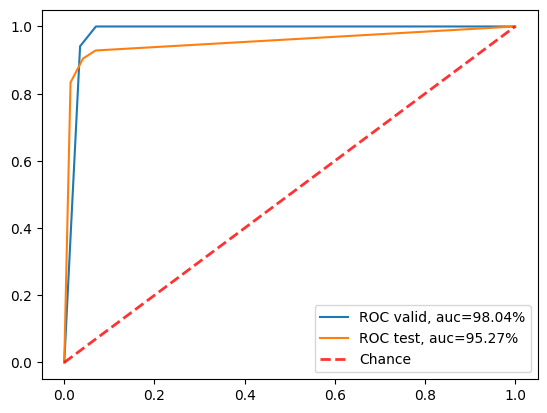

In [465]:
param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

# Compare

In [528]:
val_split1 = np.array([[55, 2], [0, 34]])
val_split2 = np.array([[55, 2], [0, 34]])
val_split3 = np.array([[55, 2], [0, 34]])
val_split4 = np.array([[53, 4], [0, 34]])
val_split5 = np.array([[57, 1], [0, 34]])

In [529]:
overall_val = val_split1 + val_split2 + val_split3 + val_split4 + val_split5
print(overall_val)

[[275  11]
 [  0 170]]


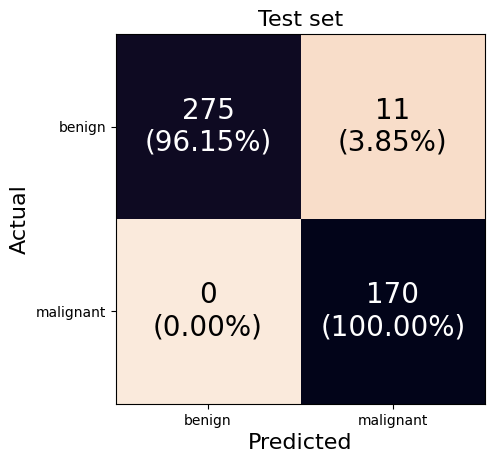

In [532]:
# plot confusion matrix
class_names = ['benign','malignant']
# Normalize confusion matrix to percentage
cm_norm_val = overall_val.astype('float') / overall_val.sum(axis=1)[:, np.newaxis]
# Create plot
fig, ax = plt.subplots()
im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
ax.grid(False)
# Add labels
ax.set(xticks=np.arange(cm_norm_val.shape[1]),
       yticks=np.arange(cm_norm_val.shape[0]),
       xticklabels=class_names, yticklabels=class_names)
ax.set_title("Test set", fontsize=16)
ax.set_ylabel('Actual', fontsize=16)
ax.set_xlabel('Predicted', fontsize=16)
# Add percentage and count values inside plot
thresh = cm_norm_val.max() / 2.
for i in range(cm_norm_val.shape[0]):
    for j in range(cm_norm_val.shape[1]):
        ax.text(j, i, '''{}\n({:.2f}%)'''.format(overall_val[i,j], cm_norm_val[i, j]*100),
                ha="center", va="center",
                color="white" if cm_norm_val[i, j] > thresh else "black", fontsize=20)
# Show plot
plt.show()

In [537]:
sensitivity_values = []

sensitivity_values.append(sen_val_split1)
sensitivity_values.append(sen_val_split2)
sensitivity_values.append(sen_val_split3)
sensitivity_values.append(sen_val_split4)
sensitivity_values.append(sen_val_split5)

print(sensitivity_values)

# calculating the mean of sample set
mean_sensitivity = statistics.mean(sensitivity_values)
# Calculate standard deviation of sensitivity
sensitivity_sd = statistics.stdev(sensitivity_values)

print("Mean Sensitivity:", mean_sensitivity)
print("Sensitivity Standard Deviation:", sensitivity_sd)

# Print mean sensitivity with standard deviation
print("Overall Sensitivity: %.2f ± %.2f%%" % (mean_sensitivity, sensitivity_sd))

NameError: name 'sen_val_split1' is not defined

In [ ]:
specificity_values = []

specificity_values.append(spec_val_split1)
specificity_values.append(spec_val_split2)
specificity_values.append(spec_val_split3)
specificity_values.append(spec_val_split4)
specificity_values.append(spec_val_split5)
    
print(specificity_values)

# calculating the mean of sample set
mean_specificity = statistics.mean(specificity_values)
# Calculate standard deviation of sensitivity
specificity_sd = statistics.stdev(specificity_values)

print("Mean Specificity:", mean_specificity)
print("Specificity Standard Deviation:", specificity_sd)

# Print mean specificity with standard deviation
print("Overall Specificity: %.2f ± %.2f%%" % (mean_specificity, specificity_sd))

In [ ]:
accuracy_values = []

accuracy_values.append(acc_val_split1)
accuracy_values.append(acc_val_split2)
accuracy_values.append(acc_val_split3)
accuracy_values.append(acc_val_split4)
accuracy_values.append(acc_val_split5)
    
print(accuracy_values)

# calculating the mean of sample set
mean_accuracy = statistics.mean(accuracy_values)
# Calculate standard deviation of sensitivity
accuracy_sd = statistics.stdev(accuracy_values)

print("Mean accuracy:", mean_accuracy)
print("accuracy Standard Deviation:", accuracy_sd)

# Print mean accuracy with standard deviation
print("Overall accuracy: %.2f ± %.2f%%" % (mean_accuracy, accuracy_sd))

In [ ]:
precision_values = []

precision_values.append(pre_val_split1)
precision_values.append(pre_val_split2)
precision_values.append(pre_val_split3)
precision_values.append(pre_val_split4)
precision_values.append(pre_val_split5)
    
print(precision_values)

# calculating the mean of sample set
mean_precision = statistics.mean(precision_values)
# Calculate standard deviation of sensitivity
precision_sd = statistics.stdev(precision_values)

print("Mean precision:", mean_precision)
print("precision Standard Deviation:", precision_sd)

# Print mean specificity with standard deviation
print("Overall precision: %.2f ± %.2f%%" % (mean_precision, precision_sd))

In [ ]:
f1_values = []

f1_values.append(f1_score_val_split1)
f1_values.append(f1_score_val_split2)
f1_values.append(f1_score_val_split3)
f1_values.append(f1_score_val_split4)
f1_values.append(f1_score_val_split5)
    
print(f1_values)

# calculating the mean of sample set
mean_f1 = statistics.mean(f1_values)
# Calculate standard deviation of sensitivity
f1_sd = statistics.stdev(f1_values)

print("Mean f1:", mean_f1)
print("f1 Standard Deviation:", f1_sd)

# Print mean specificity with standard deviation
print("Overall f1: %.2f ± %.2f%%" % (mean_f1, f1_sd))

In [ ]:
auc_values = []

auc_values.append(auc_val_split1)
auc_values.append(auc_val_split2)
auc_values.append(auc_val_split3)
auc_values.append(auc_val_split4)
auc_values.append(auc_val_split5)
    
print(auc_values)

# calculating the mean of sample set
mean_auc = statistics.mean(auc_values)
# Calculate standard deviation of sensitivity
auc_sd = statistics.stdev(auc_values)

print("Mean auc:", mean_auc)
print("auc Standard Deviation:", auc_sd)

# Print mean auc with standard deviation
print("Overall auc: %.2f ± %.2f%%" % (mean_auc, auc_sd))